# Step 1: Deciding (Not) to Segment
This step involves determining whether McDonald’s should engage in market segmentation. The decision hinges on whether creating distinct marketing strategies for different groups will result in enough additional revenue or customer satisfaction to justify the costs. McDonald’s must assess whether consumer preferences are diverse enough to warrant a segmentation approach, or if a single marketing strategy would be more effective and cost-efficient.

# Step 2: Specifying the Ideal Target Segment
In this step, McDonald’s identifies the characteristics of the ideal customer group they want to target. The ideal target segment should be homogeneous (consumers within the group share similar preferences), distinct from other segments, large enough to be profitable, and aligned with McDonald’s strengths (e.g., affordability, convenience). This process ensures McDonald's focuses on the group most likely to respond well to its offerings, optimizing resource allocation for marketing efforts.

# Step 3: Collecting Data

In [97]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score, pairwise_distances
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Mount Google Drive for Colab usage
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone/mcdonalds.csv')

# Display the names of the variables (columns)
print(df.columns)
print()
# Show the dimensions of the dataset
print("Shape of the dataset:", df.shape)
print()
# Display the first three rows
print(df.head(3))


Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

Shape of the dataset: (1453, 15)

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


# Step 4: Exploring Data

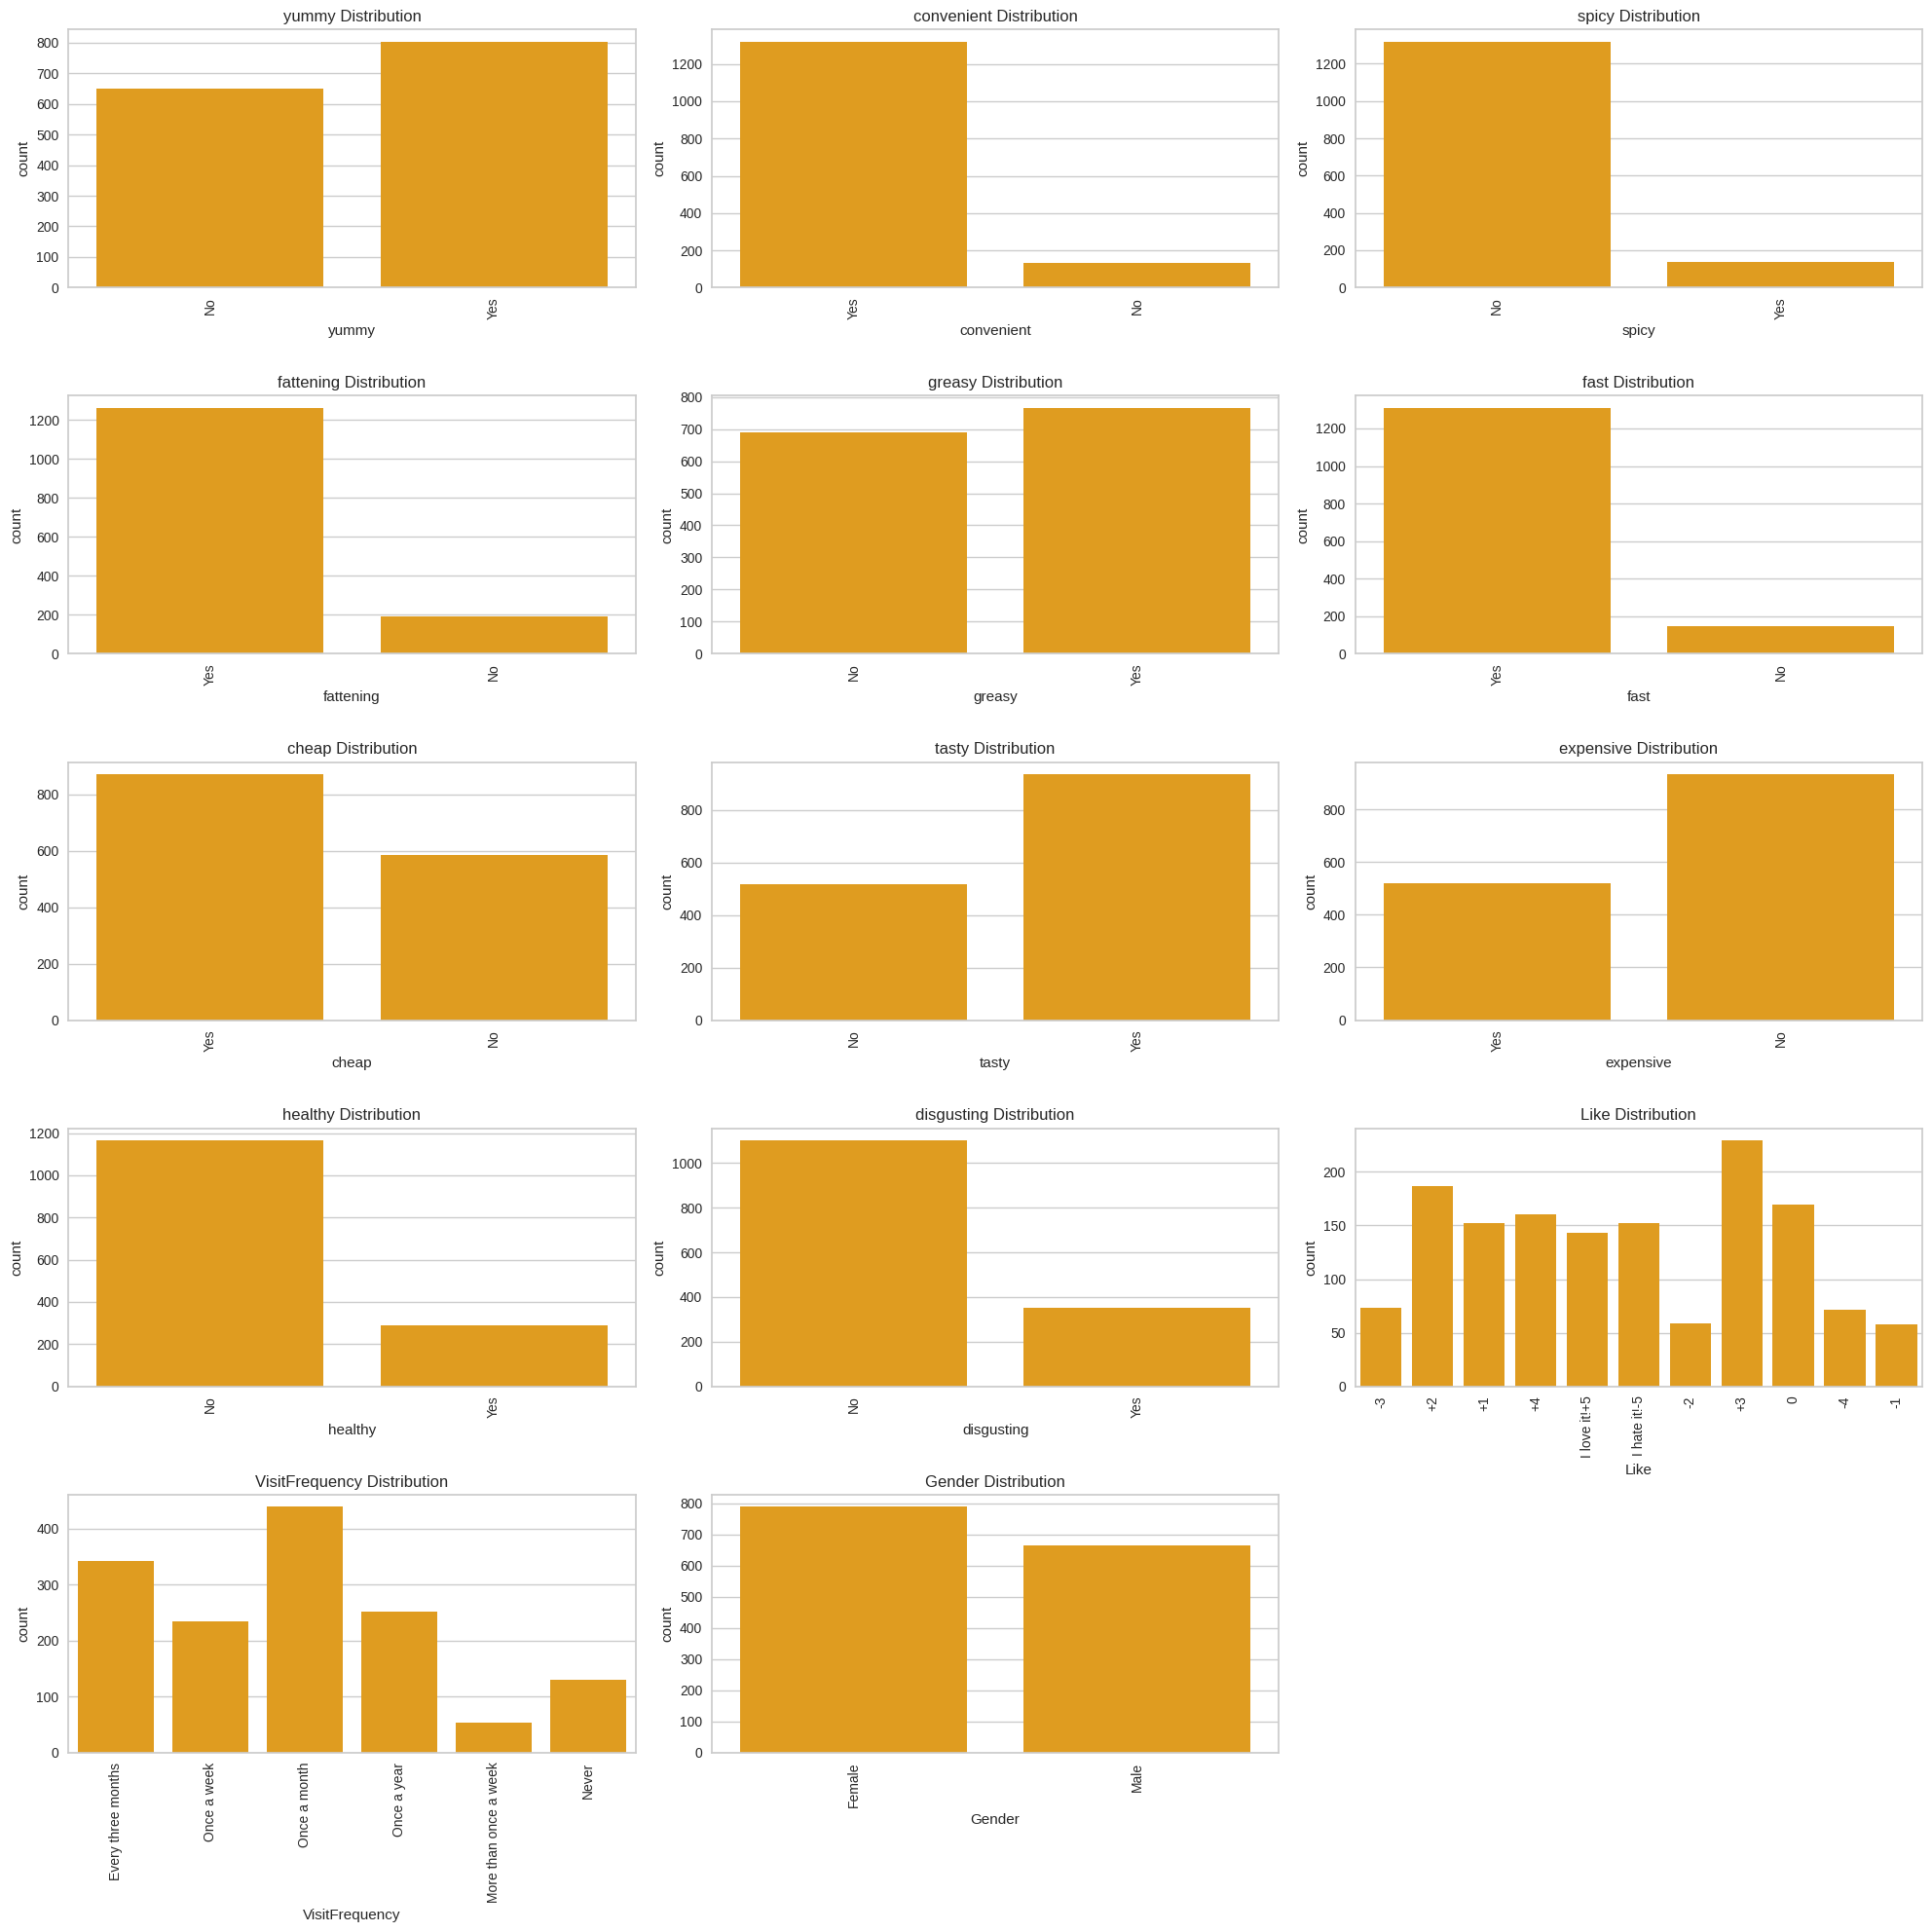

In [99]:
t = 1
plt.figure(figsize=(20, 20))

for i in df.select_dtypes(include='object').columns:
    plt.subplot(5, 3, t)
    sns.countplot(x=df[i],color="orange")
    plt.title(f'{i} Distribution')
    plt.xticks(rotation=90)
    t += 1

plt.tight_layout()
plt.show()


In [100]:
# Extract the first 11 columns (segmentation variables)
segmentation_columns = df.columns[:11]
MD_x = df[segmentation_columns].to_numpy()

# Convert 'Yes' to 1 and 'No' to 0
MD_x_numeric = np.where(MD_x == "Yes", 1, 0)
column_means = np.round(np.mean(MD_x_numeric, axis=0),2)
pd.DataFrame({'Segmentation Variables': segmentation_columns, 'Segmentation Variables Means': column_means}).T


,0,1,2,3,4,5,6,7,8,9,10
Segmentation Variables,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting
Segmentation Variables Means,0.55,0.91,0.09,0.87,0.53,0.9,0.6,0.64,0.36,0.2,0.24


In [101]:
# Perform PCA on the segmentation variables
pca = PCA()
pca.fit(MD_x_numeric)

# Print variance explained, cumulative variance and Standard Deviation
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
std_dev = np.sqrt(pca.explained_variance_)

print("Explained Variance by each component:\n", explained_variance)
print()
print("Cumulative Variance:\n", cumulative_variance)
print()
print("Standard Deviation of each PC:\n", std_dev.round(2))
print()

# Print the component loadings
loadings = pd.DataFrame(pca.components_.T, index=segmentation_columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print("Factor Loadings:")
print(loadings.round(2))

Explained Variance by each component:
 [0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]

Cumulative Variance:
 [0.29944723 0.49224445 0.6252898  0.70838558 0.7678661  0.81816566
 0.86201476 0.90156255 0.93832345 0.97067674 1.        ]

Standard Deviation of each PC:
 [0.76 0.61 0.5  0.4  0.34 0.31 0.29 0.28 0.27 0.25 0.24]

Factor Loadings:
             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy      -0.48  0.36 -0.30  0.06 -0.31  0.17 -0.28  0.01  0.57 -0.11  0.05
convenient -0.16  0.02 -0.06 -0.14  0.28 -0.35 -0.06 -0.11 -0.02 -0.67 -0.54
spicy      -0.01  0.02 -0.04  0.20  0.07 -0.36  0.71  0.38  0.40 -0.08  0.14
fattening   0.12 -0.03 -0.32 -0.35 -0.07 -0.41 -0.39  0.59 -0.16 -0.01  0.25
greasy      0.30 -0.06 -0.80  0.25  0.36  0.21  0.04 -0.14 -0.00  0.01  0.00
fast       -0.11 -0.09 -0.06 -0.10  0.11 -0.59 -0.09 -0.63  0.17  0.24  0.34
cheap      -0.34 -0.61 -0.15  0.12 -0.13 -0

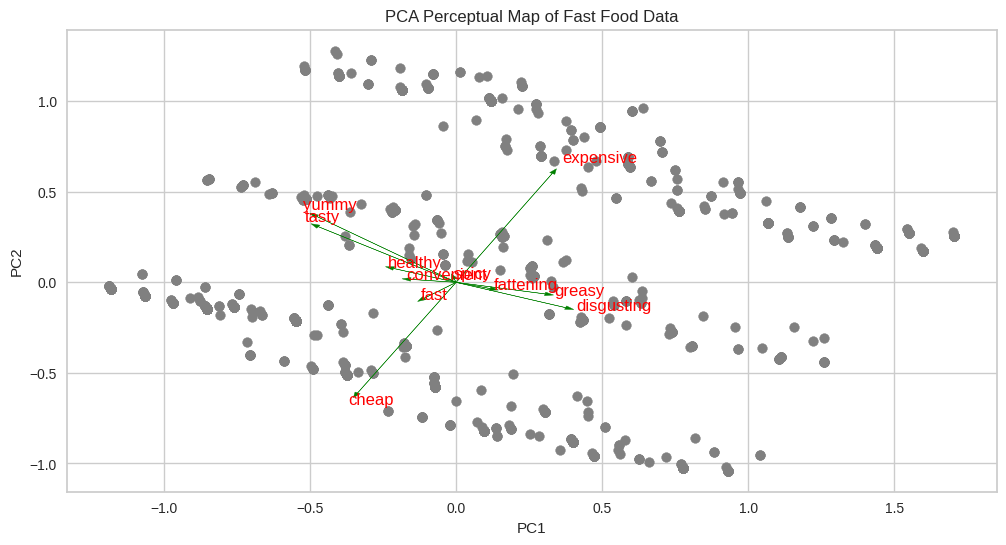

In [102]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(MD_x_numeric)

# Create a perceptual map (scatter plot) of the first two principal components
plt.figure(figsize=(12, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='grey')
loadings = pca.components_.T
for i, column in enumerate(segmentation_columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='green',head_width=0.02)
    plt.text(loadings[i,0] * 1.1, loadings[i,1] * 1.1, column, color='red')

plt.title('PCA Perceptual Map of Fast Food Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Step 5: Extracting Segments
## Using k-Means

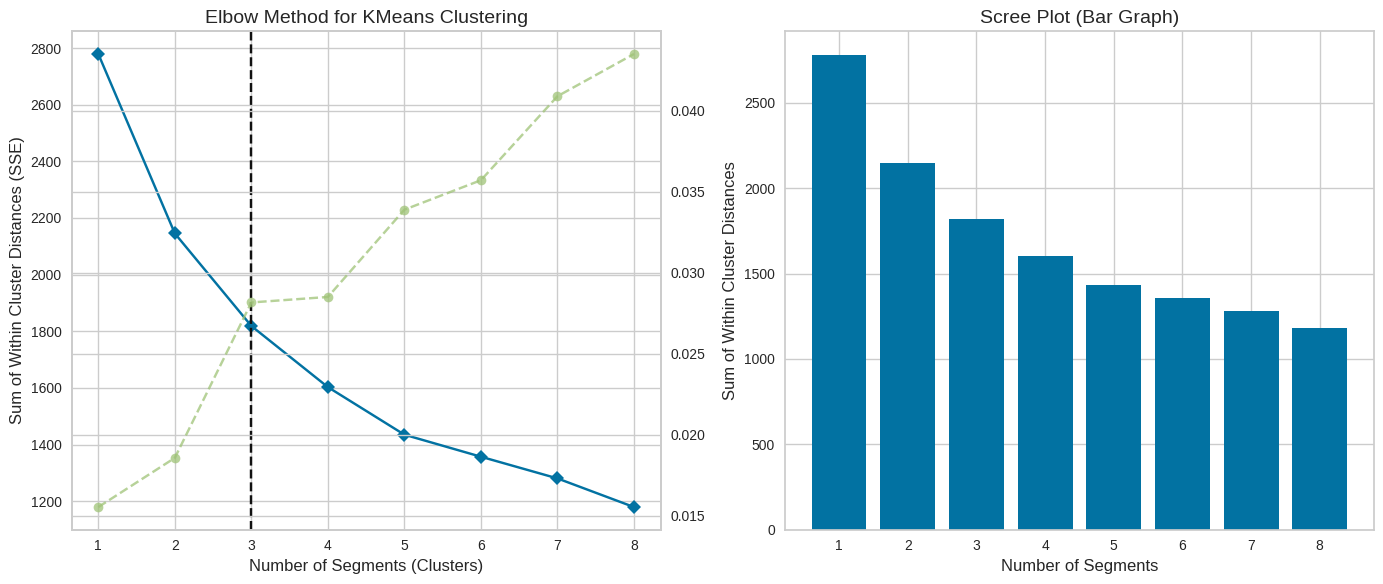

In [103]:
# Set the random seed for reproducibility
np.random.seed(1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Line plot with KElbowVisualizer
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 9), ax=axes[0])
visualizer.fit(MD_x_numeric)
axes[0].set_xlabel('Number of Segments (Clusters)', fontsize=12)
axes[0].set_ylabel('Sum of Within Cluster Distances (SSE)', fontsize=12)
axes[0].set_title('Elbow Method for KMeans Clustering', fontsize=14)

# Bar graph for Number of Segments
sse = []
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(MD_x_numeric)
    sse.append(kmeans.inertia_)

axes[1].bar(range(1, 9), sse)
axes[1].set_xlabel('Number of Segments', fontsize=12)
axes[1].set_ylabel('Sum of Within Cluster Distances', fontsize=12)
axes[1].set_title('Scree Plot (Bar Graph)', fontsize=14)
plt.tight_layout()
plt.show()

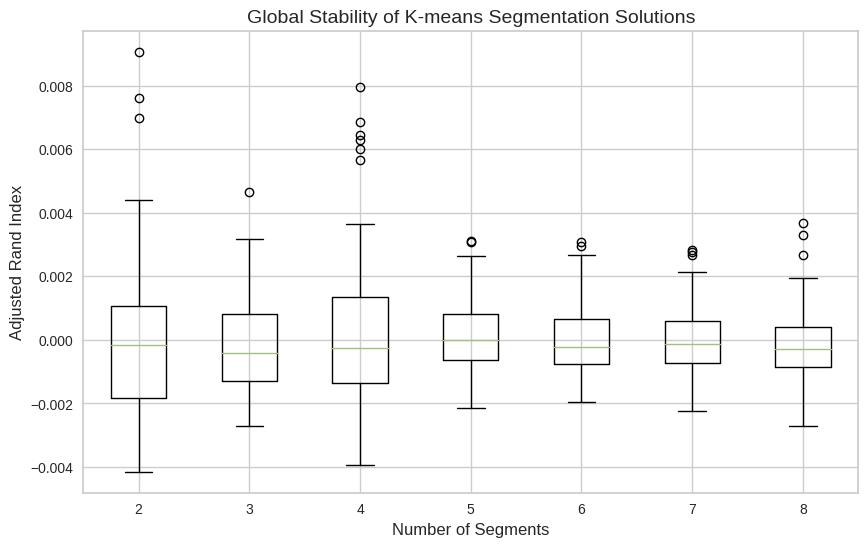

In [104]:
np.random.seed(1234)
clusters_range = range(2, 9)
n_bootstraps = 100
n_init = 10

# Store Adjusted Rand Index (ARI) for each bootstrap and number of clusters
ari_results = {k: [] for k in clusters_range}

# Perform stability analysis
for k in clusters_range:
    for _ in range(n_bootstraps):

        bootstrap_sample = resample(MD_x_numeric, replace=True)
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=1234)
        labels_bootstrap = kmeans.fit_predict(bootstrap_sample)

        # Fit K-means to the original data with the same number of clusters
        kmeans_original = KMeans(n_clusters=k, n_init=n_init, random_state=1234)
        labels_original = kmeans_original.fit_predict(MD_x_numeric)

        # Compute the Adjusted Rand Index between bootstrap and original clustering
        ari = adjusted_rand_score(labels_original, labels_bootstrap)
        ari_results[k].append(ari)

plt.figure(figsize=(10, 6))
plt.boxplot([ari_results[k] for k in clusters_range], labels=clusters_range)
plt.xlabel('Number of Segments', fontsize=12)
plt.ylabel('Adjusted Rand Index', fontsize=12)
plt.title('Global Stability of K-means Segmentation Solutions', fontsize=14)
plt.grid(True)
plt.show()

## Using Mixtures of Distributions

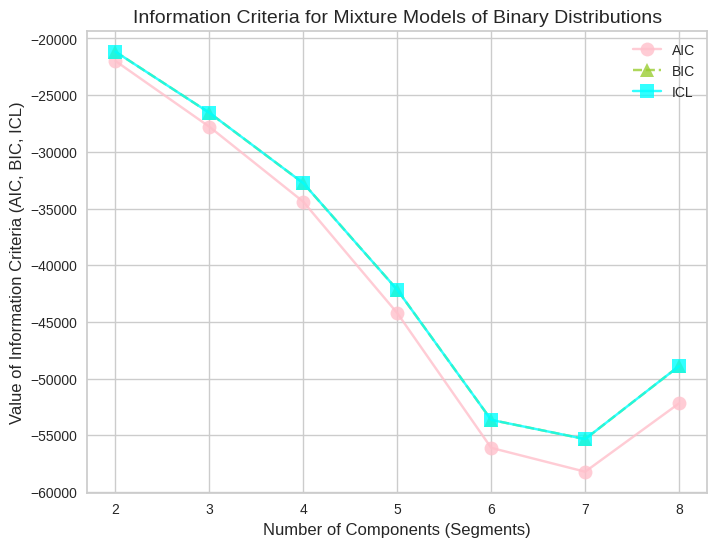

In [105]:
aic_values = []
bic_values = []
icl_values = []

# Fit Gaussian Mixture Model (GMM)
for n_components in range(2, 9):
    gmm = GaussianMixture(n_components=n_components, random_state=1234, n_init=10)
    gmm.fit(MD_x_numeric)
    aic_values.append(gmm.aic(MD_x_numeric))
    bic_values.append(gmm.bic(MD_x_numeric))
    icl_values.append(gmm.bic(MD_x_numeric))

plt.figure(figsize=(8, 6))
x_range = range(2, 9)

plt.plot(x_range, aic_values, 'o-', label='AIC', color='pink', markersize=10, alpha=0.8)
plt.plot(x_range, bic_values, '^-', label='BIC', color='yellowgreen', markersize=10, alpha=0.8, linestyle='--')
plt.plot(x_range, icl_values, 's-', label='ICL', color='cyan', markersize=10, alpha=0.8)
plt.xlabel('Number of Components (Segments)', fontsize=12)
plt.ylabel('Value of Information Criteria (AIC, BIC, ICL)', fontsize=12)
plt.title('Information Criteria for Mixture Models of Binary Distributions', fontsize=14)
plt.legend()
plt.xticks(x_range)
plt.grid(True)
plt.show()

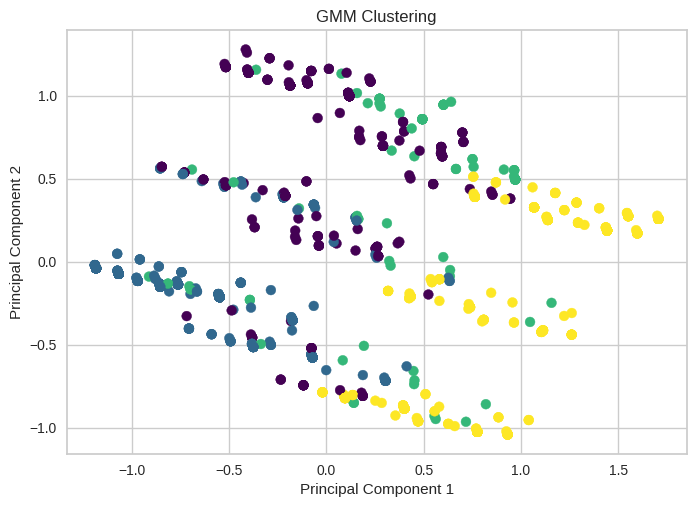

BIC: -31060.992134985954
AIC: -32703.50307635631


In [106]:
# Fit a Gaussian Mixture Model with 4 components
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# Visualize the GMM clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Evaluate the model with BIC and AIC
bic = gmm.bic(X)
aic = gmm.aic(X)

print(f"BIC: {bic}")
print(f"AIC: {aic}")


In [107]:
# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans_clusters = kmeans.fit_predict(MD_x_numeric)

# Fit a Gaussian Mixture Model (GMM) with 4 components (similar to mixture model)
gmm = GaussianMixture(n_components=4, random_state=1234)
gmm.fit(MD_x_numeric)
gmm_clusters = gmm.predict(MD_x_numeric)

# Create a cross-tabulation between kmeans and mixture model clusters
cross_tab = pd.crosstab(kmeans_clusters, gmm_clusters, rownames=['kmeans'], colnames=['mixture'])
print("Cross-tabulation between KMeans and GMM clusters:\n", cross_tab)

# Calculate Log-Likelihood for GMM with k=4
log_likelihood = gmm.score(MD_x_numeric) * MD_x_numeric.shape[0]  # score gives per-sample log-likelihood
print("\nLog-Likelihood for GMM with k=4:", log_likelihood)

Cross-tabulation between KMeans and GMM clusters:
 mixture    0    1    2    3
kmeans                     
0         99    5  253    7
1          0  211   24    5
2        500    0    0   33
3         22   38    0  256

Log-Likelihood for GMM with k=4: 13740.70387994845


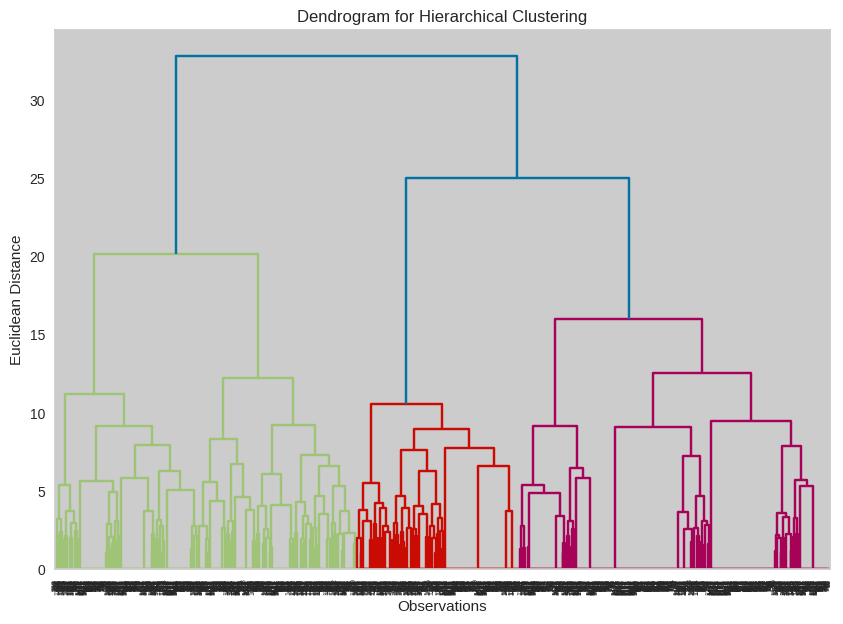

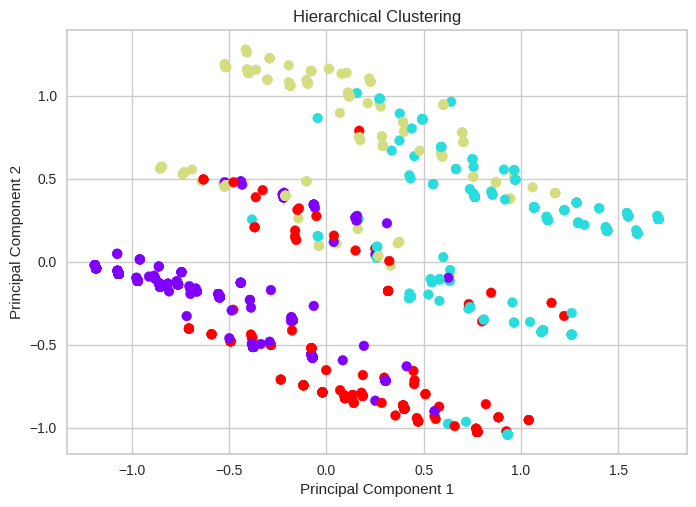

In [108]:
# Plot a dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Observations')
plt.ylabel('Euclidean Distance')
plt.show()

# Fit the Agglomerative Clustering model
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X)

# Visualize clusters (replace PCA with t-SNE if needed)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_hc, cmap='rainbow')
plt.title('Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


## Using Mixtures of Regression Models


Segment 1:
                            OLS Regression Results                            
Dep. Variable:                 Like.n   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     35.77
Date:                Wed, 11 Sep 2024   Prob (F-statistic):           3.67e-57
Time:                        15:37:22   Log-Likelihood:                -1182.9
No. Observations:                 545   AIC:                             2390.
Df Residuals:                     533   BIC:                             2441.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0641      0.434     -4.

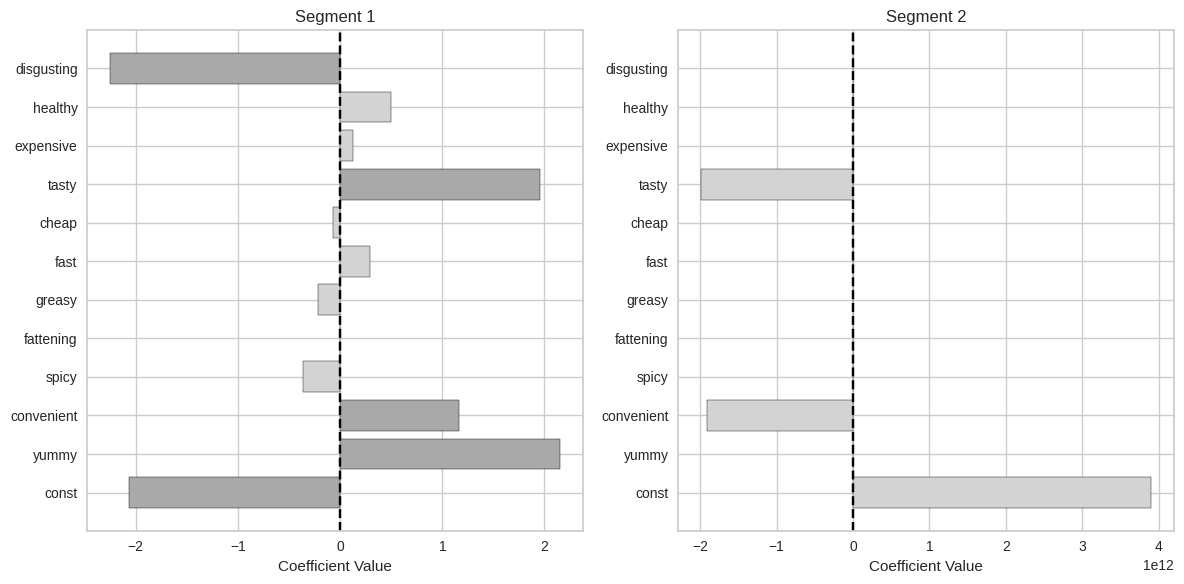

In [109]:
# Convert 'Like' into a numeric dependent variable 'Like.n'
like_mapping = {
    'I love it!+5': 1, '+4': 2, '+3': 3, '+2': 4, '+1': 5,
    '0': 6, '-1': 7, '-2': 8, '-3': 9, '-4': 10, 'I hate it!-5': 11}
df['Like.n'] = 6 - df['Like'].map(like_mapping)

# Independent variables
X = df.iloc[:, :11].replace({'Yes': 1, 'No': 0})
X = sm.add_constant(X)
y = df['Like.n']

# Fit Gaussian Mixture Model (GMM) with 2 components
gmm = GaussianMixture(n_components=2, random_state=1234)
df['Segment'] = gmm.fit_predict(X)

regression_results = {}

# Fit regression models for each segment using statsmodels
for segment in np.unique(df['Segment']):
    X_segment = X[df['Segment'] == segment]
    y_segment = y[df['Segment'] == segment]

    # Fit the regression model for the segment
    model = sm.OLS(y_segment, X_segment).fit()
    regression_results[segment] = model
    print(f"\nSegment {segment + 1}:")
    print(model.summary())

# Plot regression coefficients for both segments
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

variable_names = X.columns

# Plot coefficients for each segment
for i, segment in enumerate(regression_results):
    model = regression_results[segment]
    coef = model.params
    p_values = model.pvalues

    # Highlight significant coefficients (p-value < 0.05)
    significance = np.where(p_values < 0.05, 'darkgray', 'lightgray')
    axes[i].barh(variable_names, coef, color=significance, edgecolor='black')
    axes[i].set_title(f'Segment {segment + 1}')
    axes[i].axvline(0, color='black', linestyle='--')
    axes[i].set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

# Step 6: Profiling Segments

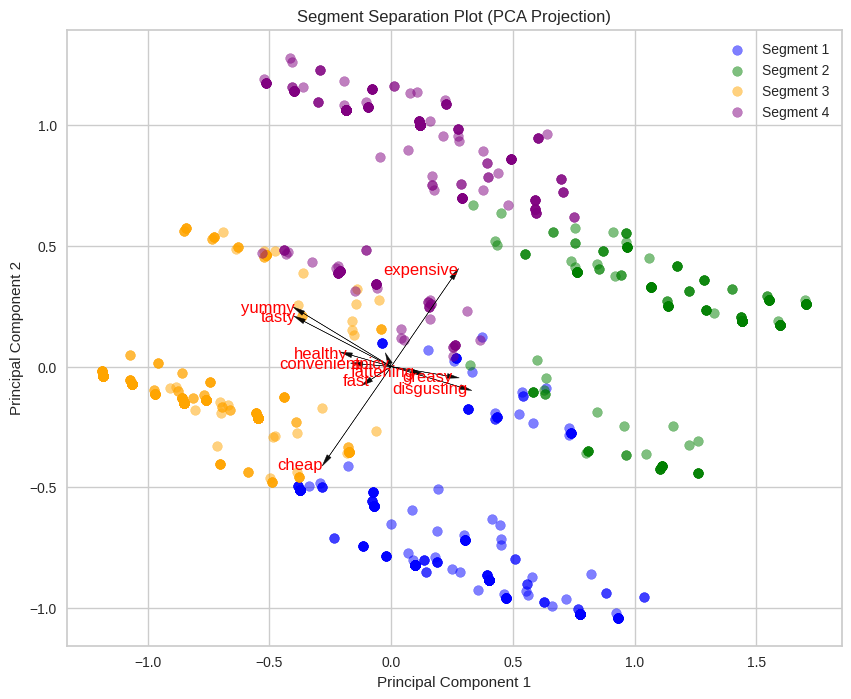

In [115]:
# Perform PCA on the dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple']
for i in range(4):
    ax.scatter(X_pca[df['Segment'] == i, 0], X_pca[df['Segment'] == i, 1],
               color=colors[i], label=f'Segment {i + 1}', alpha=0.5)

# Plot arrows for the original attributes
attributes = X.columns
for i, attribute in enumerate(attributes):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='black', alpha=0.95, head_width=0.02, head_length=0.05)
    ax.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, attribute, color='red', ha='right', va='center')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Segment Separation Plot (PCA Projection)')
ax.legend()
plt.grid(True)
plt.show()


# Step 7: Describing Segment

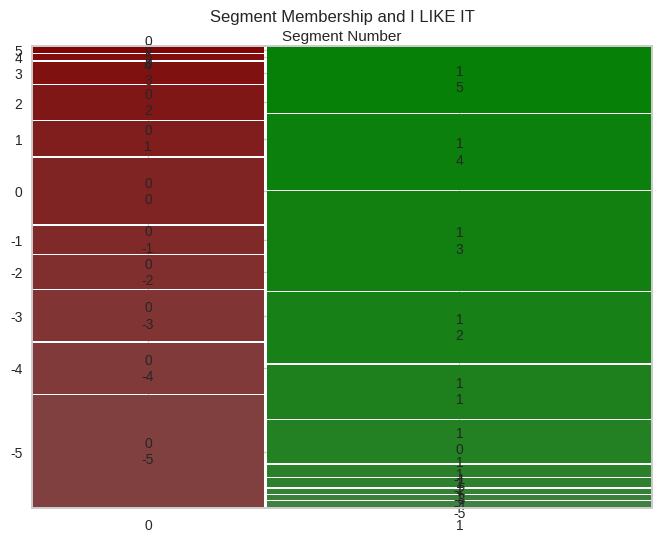

In [111]:
cross_tab_like = pd.crosstab(df['Segment'], df['Like.n'])
# Plot the shaded mosaic plot
fig, ax = plt.subplots(figsize=(8, 6))
mosaic(cross_tab_like.stack(), title='Segment Membership and I LIKE IT', ax=ax)
plt.xlabel('Segment Number')
plt.ylabel('I LIKE IT Score')
plt.show()

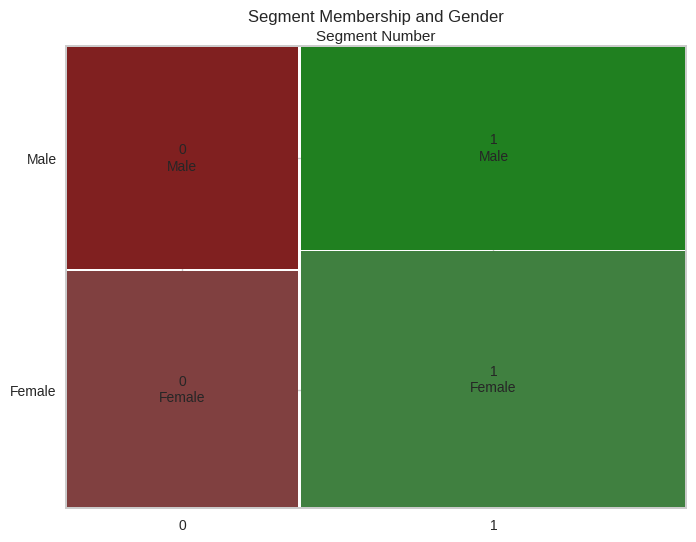

In [112]:
# Cross-tabulate the data
cross_tab_gender = pd.crosstab(df['Segment'], df['Gender'])

# Plot the shaded mosaic plot for Gender
fig, ax = plt.subplots(figsize=(8, 6))
mosaic(cross_tab_gender.stack(), title='Segment Membership and Gender', ax=ax)
plt.xlabel('Segment Number')
plt.ylabel('Gender')
plt.show()



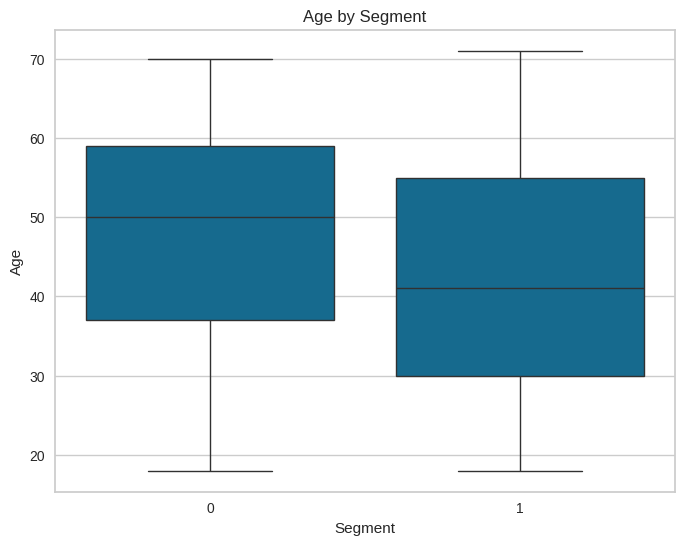

In [113]:
# Plot the box-and-whisker plot for Age by Segment
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Segment', y='Age', data=df, ax=ax)
ax.set_title('Age by Segment')
plt.show()


# Step 8: Selecting (the) Target Segment(s)

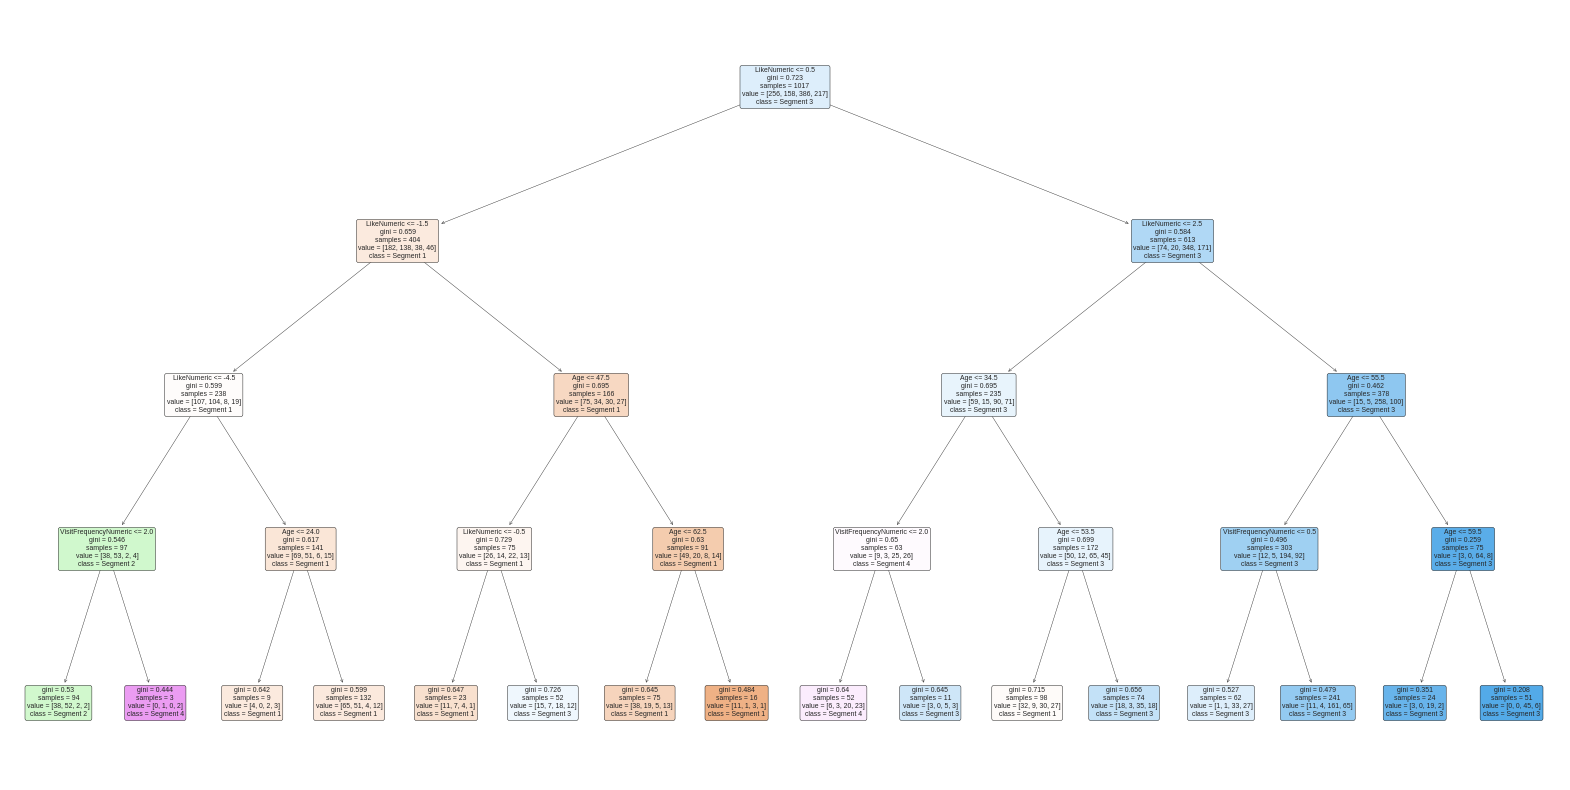

In [114]:
# Prepare the target variable ('Segment') by running KMeans clustering
X = df.iloc[:, :11].replace({'Yes': 1, 'No': 0})
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=1234)
df['Segment'] = kmeans.fit_predict(X)

visit_mapping = {'Every day': 5, 'Several times a week': 4, 'Once a week': 3, '2-3 times a month': 2,'Once a month': 1, 'Less than once a month': 0}
like_mapping = {'I love it!+5': 5, '+4': 4, '+3': 3, '+2': 2, '+1': 1,'0': 0, '-1': -1, '-2': -2, '-3': -3, '-4': -4, 'I hate it!-5': -5}
df['VisitFrequencyNumeric'] = df['VisitFrequency'].map(visit_mapping)
df['LikeNumeric'] = df['Like'].map(like_mapping)

# Select relevant features
features = ['VisitFrequencyNumeric', 'LikeNumeric', 'Age']
X_tree = df[features].fillna(0)
y_tree = df['Segment']

X_train, X_test, y_train, y_test = train_test_split(X_tree, y_tree, test_size=0.3, random_state=42)
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=[f'Segment {i+1}' for i in range(4)], filled=True, rounded=True)
plt.show()